# Decision trees

A decision tree is a supervised learning method that can be used for classification and regression. It consists of a structure in which internal nodes represent tests on attributes, and the branches from nodes represent the result of those tests. Each leaf node is a class label and the paths from root to leaf nodes define the set of classification or regression rules.

In [34]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [35]:
# Greenplum Database 5.4.0 on GCP (demo machine)
#%sql postgresql://gpadmin@35.184.253.255:5432/madlib
        
# PostgreSQL local
%sql postgresql://fmcquillan@localhost:5432/madlib

# Greenplum Database 4.3.10.0
#%sql postgresql://gpdbchina@10.194.10.68:61000/madlib

u'Connected: fmcquillan@madlib'

In [ ]:
%sql select madlib.version();
#%sql select version();

# Decision tree classification examples

# 1. Load data
Data set related to whether to play golf or not.

In [36]:
%%sql
DROP TABLE IF EXISTS dt_golf CASCADE;

CREATE TABLE dt_golf (
    id integer NOT NULL,
    "OUTLOOK" text,
    temperature double precision,
    humidity double precision,
    "Temp_Humidity" double precision[],
    clouds_airquality text[],
    windy boolean,
    class text,
    observation_weight double precision
);

INSERT INTO dt_golf VALUES
(1,'sunny', 85, 85, ARRAY[85, 85],ARRAY['none', 'unhealthy'], 'false','Don''t Play', 5.0),
(2, 'sunny', 80, 90, ARRAY[80, 90], ARRAY['none', 'moderate'], 'true', 'Don''t Play', 5.0),
(3, 'overcast', 83, 78, ARRAY[83, 78], ARRAY['low', 'moderate'], 'false', 'Play', 1.5),
(4, 'rain', 70, 96, ARRAY[70, 96], ARRAY['low', 'moderate'], 'false', 'Play', 1.0),
(5, 'rain', 68, 80, ARRAY[68, 80], ARRAY['medium', 'good'], 'false', 'Play', 1.0),
(6, 'rain', 65, 70, ARRAY[65, 70], ARRAY['low', 'unhealthy'], 'true', 'Don''t Play', 1.0),
(7, 'overcast', 64, 65, ARRAY[64, 65], ARRAY['medium', 'moderate'], 'true', 'Play', 1.5),
(8, 'sunny', 72, 95, ARRAY[72, 95], ARRAY['high', 'unhealthy'], 'false', 'Don''t Play', 5.0),
(9, 'sunny', 69, 70, ARRAY[69, 70], ARRAY['high', 'good'], 'false', 'Play', 5.0),
(10, 'rain', 75, 80, ARRAY[75, 80], ARRAY['medium', 'good'], 'false', 'Play', 1.0),
(11, 'sunny', 75, 70, ARRAY[75, 70], ARRAY['none', 'good'], 'true', 'Play', 5.0),
(12, 'overcast', 72, 90, ARRAY[72, 90], ARRAY['medium', 'moderate'], 'true', 'Play', 1.5),
(13, 'overcast', 81, 75, ARRAY[81, 75], ARRAY['medium', 'moderate'], 'false', 'Play', 1.5),
(14, 'rain', 71, 80, ARRAY[71, 80], ARRAY['low', 'unhealthy'], 'true', 'Don''t Play', 1.0);

SELECT * FROM dt_golf ORDER BY id;

Done.
Done.
14 rows affected.
14 rows affected.


id,OUTLOOK,temperature,humidity,Temp_Humidity,clouds_airquality,windy,class,observation_weight
1,sunny,85.0,85.0,"[85.0, 85.0]","[u'none', u'unhealthy']",False,Don't Play,5.0
2,sunny,80.0,90.0,"[80.0, 90.0]","[u'none', u'moderate']",True,Don't Play,5.0
3,overcast,83.0,78.0,"[83.0, 78.0]","[u'low', u'moderate']",False,Play,1.5
4,rain,70.0,96.0,"[70.0, 96.0]","[u'low', u'moderate']",False,Play,1.0
5,rain,68.0,80.0,"[68.0, 80.0]","[u'medium', u'good']",False,Play,1.0
6,rain,65.0,70.0,"[65.0, 70.0]","[u'low', u'unhealthy']",True,Don't Play,1.0
7,overcast,64.0,65.0,"[64.0, 65.0]","[u'medium', u'moderate']",True,Play,1.5
8,sunny,72.0,95.0,"[72.0, 95.0]","[u'high', u'unhealthy']",False,Don't Play,5.0
9,sunny,69.0,70.0,"[69.0, 70.0]","[u'high', u'good']",False,Play,5.0
10,rain,75.0,80.0,"[75.0, 80.0]","[u'medium', u'good']",False,Play,1.0


# 2.  Train decision tree
Train tree then view the output table (excluding the tree which is in binary format):

In [37]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary;

SELECT madlib.tree_train('dt_golf',         -- source table
                         'train_output',    -- output model table
                         'id',              -- id column
                         'class',           -- response
                         '"OUTLOOK", temperature, windy',   -- features
                         NULL::text,        -- exclude columns
                         'gini',            -- split criterion
                         NULL::text,        -- no grouping
                         NULL::text,        -- no weights, all observations treated equally
                         5,                 -- max depth
                         3,                 -- min split
                         1,                 -- min bucket
                         10                 -- number of bins per continuous variable
                         );

SELECT pruning_cp, cat_levels_in_text, cat_n_levels, tree_depth FROM train_output;

Done.
1 rows affected.
1 rows affected.


pruning_cp,cat_levels_in_text,cat_n_levels,tree_depth
0,"[u'overcast', u'sunny', u'rain', u'False', u'True']","[3, 2]",5


Review the summary table:

In [38]:
%%sql
SELECT * FROM train_output_summary;

1 rows affected.


method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,input_cp,independent_var_types,k,null_proxy
tree_train,True,dt_golf,train_output,id,class,"""OUTLOOK"", temperature, windy","""OUTLOOK"",windy",temperature,None,1,0,14,0,"""Don't Play"",""Play""",text,0.0,"text, boolean, double precision",None,NULL


# 3. Predict
Predict output categories.  For the purpose of this example, we use the same data that was used for training:

In [39]:
%%sql
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.tree_predict('train_output',          -- tree model
                           'dt_golf',               -- new data table
                           'prediction_results',    -- output table
                           'response');             -- show response

SELECT g.id, class, estimated_class FROM prediction_results p, 
dt_golf g WHERE p.id = g.id ORDER BY g.id;

Done.
1 rows affected.
14 rows affected.


id,class,estimated_class
1,Don't Play,Don't Play
2,Don't Play,Don't Play
3,Play,Play
4,Play,Play
5,Play,Play
6,Don't Play,Don't Play
7,Play,Play
8,Don't Play,Don't Play
9,Play,Play
10,Play,Play


To display the probabilities associated with each value of the dependent variable, set the 'type' parameter to 'prob':

In [40]:
%%sql
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.tree_predict('train_output',          -- tree model
                           'dt_golf',               -- new data table
                           'prediction_results',    -- output table
                           'prob');                 -- show probability

SELECT g.id, class, "estimated_prob_Don't Play",  "estimated_prob_Play" 
FROM prediction_results p, dt_golf g WHERE p.id = g.id ORDER BY g.id;

Done.
1 rows affected.
14 rows affected.


id,class,estimated_prob_Don't Play,estimated_prob_Play
1,Don't Play,1.0,0.0
2,Don't Play,1.0,0.0
3,Play,0.0,1.0
4,Play,0.0,1.0
5,Play,0.0,1.0
6,Don't Play,1.0,0.0
7,Play,0.0,1.0
8,Don't Play,1.0,0.0
9,Play,0.0,1.0
10,Play,0.0,1.0


# 4. View tree in text format

In [41]:
%%sql
SELECT madlib.tree_display('train_output', FALSE);

1 rows affected.


tree_display
"------------------------------------- - Each node represented by 'id' inside (). - Each internal nodes has the split condition at the end, while each leaf node has a * at the end. - For each internal node (i), its child nodes are indented by 1 level with ids (2i+1) for True node and (2i+2) for False node. - Number of (weighted) rows for each response variable inside [].' The response label order is given as ['""Don\'t Play""', '""Play""']. For each leaf, the prediction is given after the '-->' -------------------------------------(0)[5 9] ""OUTLOOK"" in {overcast} (1)[0 4] * --> ""Play"" (2)[5 5] temperature <= 75 (5)[3 5] temperature <= 65 (11)[1 0] * --> ""Don't Play"" (12)[2 5] temperature <= 70 (25)[0 3] * --> ""Play"" (26)[2 2] temperature <= 72 (53)[2 0] * --> ""Don't Play"" (54)[0 2] * --> ""Play"" (6)[2 0] * --> ""Don't Play""-------------------------------------"


Here are some more details on how to interpret the tree display above:

* Node numbering starts at 0 for the root node and would be contiguous 1,2...n if the tree was completely full (no pruning). Since the tree has been pruned, the node numbering is not contiguous.

* The order of values [x y] indicates the number of weighted rows that correspond to ["Don't play" "Play"] before the node test. For example, at (root) node 0, there are 5 rows for "Don't play" and 9 rows for "Play" in the raw data.

* If we apply the test of "OUTLOOK" being overcast, then the True (yes) result is leaf node 1 which is "Play". There are 0 "Don't play" rows and 4 "Play" rows that correspond to this case (overcast). In other words, if it is overcast, you always play golf. If it is not overcast, you may or may not play golf, depending on the rest of the tree.

* The remaining 5 "Don't play" rows and 5 "Play rows" are then tested at node 2 on temperature<=75. The False (no) result is leaf node 6 which is "Don't Play". The True (yes) result proceeds to leaf node 5 to test on temperature<=65. And so on down the tree.

# 5. View tree in dot format

In [42]:
%%sql
SELECT madlib.tree_display('train_output', TRUE);

1 rows affected.


tree_display
"digraph ""Classification tree for dt_golf"" { subgraph ""cluster0""{ label=""""""g0_0"" [label=""\""OUTLOOK\"" <= overcast"", shape=ellipse];""g0_0"" -> ""g0_1""[label=""yes""];""g0_1"" [label=""\""Play\"""",shape=box];""g0_0"" -> ""g0_2""[label=""no""];""g0_2"" [label=""temperature <= 75"", shape=ellipse];""g0_2"" -> ""g0_5""[label=""yes""];""g0_2"" -> ""g0_6""[label=""no""];""g0_6"" [label=""\""Don't Play\"""",shape=box];""g0_5"" [label=""temperature <= 65"", shape=ellipse];""g0_5"" -> ""g0_11""[label=""yes""];""g0_11"" [label=""\""Don't Play\"""",shape=box];""g0_5"" -> ""g0_12""[label=""no""];""g0_12"" [label=""temperature <= 70"", shape=ellipse];""g0_12"" -> ""g0_25""[label=""yes""];""g0_25"" [label=""\""Play\"""",shape=box];""g0_12"" -> ""g0_26""[label=""no""];""g0_26"" [label=""temperature <= 72"", shape=ellipse];""g0_26"" -> ""g0_53""[label=""yes""];""g0_53"" [label=""\""Don't Play\"""",shape=box];""g0_26"" -> ""g0_54""[label=""no""];""g0_54"" [label=""\""Play\"""",shape=box]; } //--- end of subgraph------------} //---end of digraph---------"


# 6. View tree in dot format with additional information

In [43]:
%%sql
SELECT madlib.tree_display('train_output', TRUE, TRUE);

1 rows affected.


tree_display
"digraph ""Classification tree for dt_golf"" { subgraph ""cluster0""{ label=""""""g0_0"" [label=""\""OUTLOOK\"" <= overcast\n impurity = 0.459184\n samples = 14\n value = [5 9]\n class = \""Play\"""", shape=ellipse];""g0_0"" -> ""g0_1""[label=""yes""];""g0_1"" [label=""\""Play\""\n impurity = 0\n samples = 4\n value = [0 4]"",shape=box];""g0_0"" -> ""g0_2""[label=""no""];""g0_2"" [label=""temperature <= 75\n impurity = 0.5\n samples = 10\n value = [5 5]\n class = \""Don't Play\"""", shape=ellipse];""g0_2"" -> ""g0_5""[label=""yes""];""g0_2"" -> ""g0_6""[label=""no""];""g0_6"" [label=""\""Don't Play\""\n impurity = 0\n samples = 2\n value = [2 0]"",shape=box];""g0_5"" [label=""temperature <= 65\n impurity = 0.46875\n samples = 8\n value = [3 5]\n class = \""Play\"""", shape=ellipse];""g0_5"" -> ""g0_11""[label=""yes""];""g0_11"" [label=""\""Don't Play\""\n impurity = 0\n samples = 1\n value = [1 0]"",shape=box];""g0_5"" -> ""g0_12""[label=""no""];""g0_12"" [label=""temperature <= 70\n impurity = 0.408163\n samples = 7\n value = [2 5]\n class = \""Play\"""", shape=ellipse];""g0_12"" -> ""g0_25""[label=""yes""];""g0_25"" [label=""\""Play\""\n impurity = 0\n samples = 3\n value = [0 3]"",shape=box];""g0_12"" -> ""g0_26""[label=""no""];""g0_26"" [label=""temperature <= 72\n impurity = 0.5\n samples = 4\n value = [2 2]\n class = \""Don't Play\"""", shape=ellipse];""g0_26"" -> ""g0_53""[label=""yes""];""g0_53"" [label=""\""Don't Play\""\n impurity = 0\n samples = 2\n value = [2 0]"",shape=box];""g0_26"" -> ""g0_54""[label=""no""];""g0_54"" [label=""\""Play\""\n impurity = 0\n samples = 2\n value = [0 2]"",shape=box]; } //--- end of subgraph------------} //---end of digraph---------"


You may wish to visualize the tree using pygraphviz or another program that can handle dot format:

1 rows affected.
True


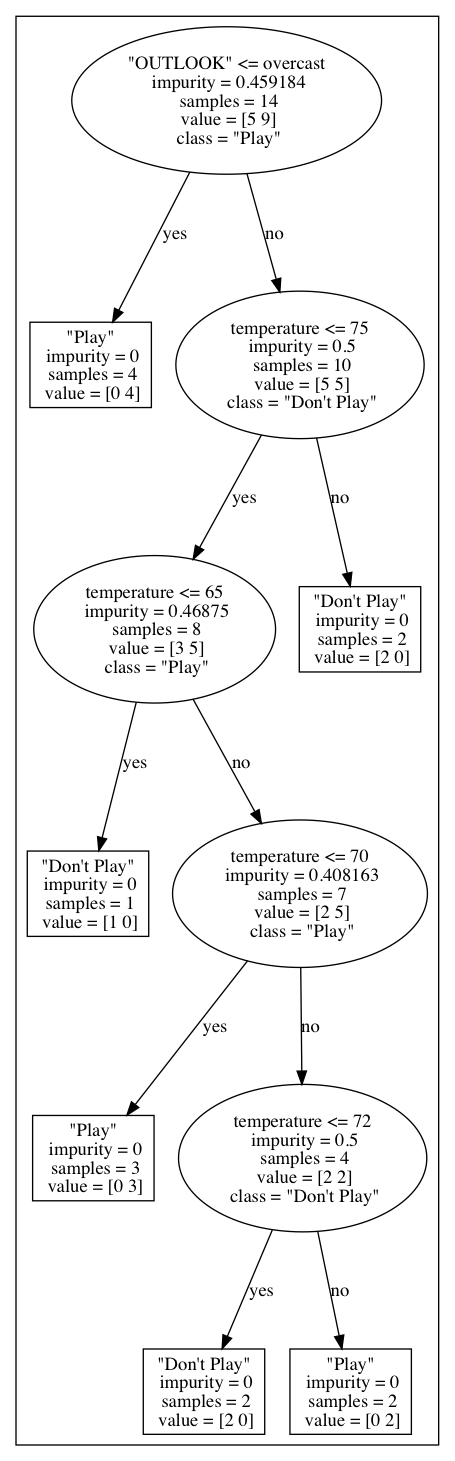

In [45]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.tree_display('train_output', TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

One important difference to note about the dot format above is how categorical variable tests are displayed:

* In the text format of the tree, the node 0 test is "OUTLOOK" in {overcast}, but in the dot format of the tree, the same node 0 test reads "\"OUTLOOK" <= overcast". This is because in dot format for categorical variables, the '<=' symbol represents the location in the array 'cat_levels_in_text' from the output table for the "OUTLOOK" levels. The array is ['overcast', 'rain', 'sunny', 'False', 'True'] with the first 3 entries corresponding to "OUTLOOK" and the last 2 entries corresponding to 'windy'. So the test "\"OUTLOOK" <= overcast" means all "OUTLOOK" levels to the left of, and including, 'overcast'. In this case there are no levels to the left of 'overcast' in the array so it is simply a test on whether it is overcast or not.

* If there was a test "\"OUTLOOK" <= rain", this would include both 'overcast' and 'rain', since 'overcast' is to the left of 'rain' in the array.

* If there was a test "windy <= True", this would include both 'False' and 'True', since 'False' is to the left of 'True' in the array.

# 7. Arrays of features
Categorical and continuous features can be array columns, in which case the array is expanded to treat each element of the array as a feature.

In [ ]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary;

SELECT madlib.tree_train('dt_golf',         -- source table
                         'train_output',    -- output model table
                         'id',              -- id column
                         'class',           -- response
                         '"Temp_Humidity", clouds_airquality',   -- features
                         NULL::text,        -- exclude columns
                         'gini',            -- split criterion
                         NULL::text,        -- no grouping
                         NULL::text,        -- no weights, all observations treated equally
                         5,                 -- max depth
                         3,                 -- min split
                         1,                 -- min bucket
                         10                 -- number of bins per continuous variable
                         );

SELECT pruning_cp, cat_levels_in_text, cat_n_levels, tree_depth FROM train_output;

The first 4 levels above correspond to cloud ceiling and the next 3 levels correspond to air quality.  Output the summary output shows the categorical and continuous variables:

In [ ]:
%%sql
select * from train_output_summary;

# 8. Weighting observations
Use the 'weights' parameter to adjust a row's vote to balance the dataset.  In our example, the weights are somewhat random but show that a different decision tree is create compared to the case where no weights are used:

In [ ]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary;

SELECT madlib.tree_train('dt_golf',         -- source table
                         'train_output',    -- output model table
                         'id',              -- id column
                         'class',           -- response
                         '"OUTLOOK", temperature, windy',   -- features
                         NULL::text,        -- exclude columns
                         'gini',            -- split criterion
                         NULL::text,        -- no grouping
                         'observation_weight', -- weight observations
                         5,                 -- max depth
                         3,                 -- min split
                         1,                 -- min bucket
                         10                 -- number of bins per continuous variable
                         );

SELECT madlib.tree_display('train_output', FALSE);

In [ ]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.tree_display('train_output', TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

# Decision tree regression examples

# 1. Load data
Data set related to fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973–74 models). Data was extracted from the 1974 Motor Trend US magazine.

In [ ]:
%%sql
DROP TABLE IF EXISTS mt_cars;

CREATE TABLE mt_cars (
    id integer NOT NULL,
    mpg double precision,
    cyl integer,
    disp double precision,
    hp integer,
    drat double precision,
    wt double precision,
    qsec double precision,
    vs integer,
    am integer,
    gear integer,
    carb integer
);

INSERT INTO mt_cars VALUES
(1,18.7,8,360,175,3.15,3.44,17.02,0,0,3,2),
(2,21,6,160,110,3.9,2.62,16.46,0,1,4,4),
(3,24.4,4,146.7,62,3.69,3.19,20,1,0,4,2),
(4,21,6,160,110,3.9,2.875,17.02,0,1,4,4),
(5,17.8,6,167.6,123,3.92,3.44,18.9,1,0,4,4),
(6,16.4,8,275.8,180,3.078,4.07,17.4,0,0,3,3),
(7,22.8,4,108,93,3.85,2.32,18.61,1,1,4,1),
(8,17.3,8,275.8,180,3.078,3.73,17.6,0,0,3,3),
(9,21.4,null,258,110,3.08,3.215,19.44,1,0,3,1),
(10,15.2,8,275.8,180,3.078,3.78,18,0,0,3,3),
(11,18.1,6,225,105,2.768,3.46,20.22,1,0,3,1),
(12,32.4,4,78.7,66,4.08,2.20,19.47,1,1,4,1),
(13,14.3,8,360,245,3.21,3.578,15.84,0,0,3,4),
(14,22.8,4,140.8,95,3.92,3.15,22.9,1,0,4,2),
(15,30.4,4,75.7,52,4.93,1.615,18.52,1,1,4,2),
(16,19.2,6,167.6,123,3.92,3.44,18.3,1,0,4,4),
(17,33.9,4,71.14,65,4.22,1.835,19.9,1,1,4,1),
(18,15.2,null,304,150,3.15,3.435,17.3,0,0,3,2),
(19,10.4,8,472,205,2.93,5.25,17.98,0,0,3,4),
(20,27.3,4,79,66,4.08,1.935,18.9,1,1,4,1),
(21,10.4,8,460,215,3,5.424,17.82,0,0,3,4),
(22,26,4,120.3,91,4.43,2.14,16.7,0,1,5,2),
(23,14.7,8,440,230,3.23,5.345,17.42,0,0,3,4),
(24,30.4,4,95.14,113,3.77,1.513,16.9,1,1,5,2),
(25,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1),
(26,15.8,8,351,264,4.22,3.17,14.5,0,1,5,4),
(27,15.5,8,318,150,2.768,3.52,16.87,0,0,3,2),
(28,15,8,301,335,3.54,3.578,14.6,0,1,5,8),
(29,13.3,8,350,245,3.73,3.84,15.41,0,0,3,4),
(30,19.2,8,400,175,3.08,3.845,17.05,0,0,3,2),
(31,19.7,6,145,175,3.62,2.77,15.5,0,1,5,6),
(32,21.4,4,121,109,4.11,2.78,18.6,1,1,4,2);

SELECT * FROM mt_cars ORDER BY id;

# 2.  Train decision tree with surrogates
We train a regression decision tree with surrogates in order to handle the NULL feature values:

In [ ]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary, train_output_cv;

SELECT madlib.tree_train('mt_cars',         -- source table
                         'train_output',    -- output model table
                         'id',              -- id column
                         'mpg',             -- dependent variable
                         '*',               -- features
                         'id, hp, drat, am, gear, carb',  -- exclude columns
                         'mse',             -- split criterion
                         NULL::text,        -- no grouping
                         NULL::text,        -- no weights, all observations treated equally
                         10,                -- max depth
                         8,                 -- min split
                         3,                 -- number of bins per continuous variable
                         10,                -- number of splits
                         NULL,              -- pruning parameters
                         'max_surrogates=2' -- number of surrogates
                         );

SELECT pruning_cp, cat_levels_in_text, cat_n_levels, tree_depth FROM train_output;

In [ ]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary, train_output_cv;

SELECT madlib.tree_train('mt_cars',         -- source table
                         'train_output',    -- output model table
                         'id',              -- id column
                         'mpg',             -- dependent variable
                         '*',               -- features
                         'id, hp, drat, am, gear, carb',  -- exclude columns
                         'mse',             -- split criterion
                         NULL::text,        -- no grouping
                         NULL::text,        -- no weights, all observations treated equally
                         10,                -- max depth
                         8,                 -- min split
                         3,                 -- number of bins per continuous variable
                         10,                -- number of splits
                         NULL,              -- pruning parameters
                         'max_surrogates=2' -- number of surrogates
                         );

SELECT pruning_cp, cat_levels_in_text, cat_n_levels, tree_depth FROM train_output;

Above shows ordering of levels of categorical variables 'vs' and 'cyl'.  View the summary table:

In [ ]:
%%sql
SELECT * FROM train_output_summary;

# 3. Predict

Predict regression output for the same data and compare with original:

In [ ]:
%%sql
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.tree_predict('train_output',
                           'mt_cars',
                           'prediction_results',
                           'response');

SELECT s.id, mpg, estimated_mpg, mpg-estimated_mpg as delta FROM prediction_results p, 
mt_cars s WHERE s.id = p.id ORDER BY id;

# 4.  View tree

In [ ]:
%%sql
SELECT madlib.tree_display('train_output', FALSE);

In [ ]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.tree_display('train_output', TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

# 5. Display the surrogate variables
Display the surrogate variables that are used to compute the split for each node when the primary variable is NULL:

In [ ]:
%%sql
SELECT madlib.tree_surr_display('train_output');

# 6.  Cross validation
Use cross validation to select the best value of the complexity parameter cp:

In [ ]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary, train_output_cv;

SELECT madlib.tree_train('mt_cars',         -- source table
                         'train_output',    -- output model table
                         'id',              -- id column
                         'mpg',             -- dependent variable
                         '*',               -- features
                         'id, hp, drat, am, gear, carb',  -- exclude columns
                         'mse',             -- split criterion
                         NULL::text,        -- no grouping
                         NULL::text,        -- no weights, all observations treated equally
                         10,                -- max depth
                         8,                 -- min split
                         3,                 -- number of bins per continuous variable
                         10,                -- number of splits
                         'n_folds=3'       -- pruning parameters for cross validation
                         );

SELECT pruning_cp, cat_levels_in_text, cat_n_levels, tree_depth FROM train_output;

The input cp value was 0 (default) and the best 'pruning_cp' value turns out to be 0 as well in this small example.  The cp values tested and average error and standard deviation are:

In [ ]:
%%sql
SELECT * FROM train_output_cv ORDER BY cv_error_avg ASC;

# NULL handling example

# 1. Load data
Create toy example to illustrate null-as-category handling for categorical features:

In [ ]:
%%sql
DROP TABLE IF EXISTS null_handling_example;

CREATE TABLE null_handling_example (
    id integer,
    country text,
    city text,
    weather text,
    response text
);
 
INSERT INTO null_handling_example VALUES
(1,null,null,null,'a'),
(2,'US',null,null,'b'),
(3,'US','NY',null,'c'),
(4,'US','NY','rainy','d');
 
SELECT * FROM null_handling_example;

# 2. Train decision tree 
Note that '__NULL__' is set as a valid level for the categorical features country, weather and city:

In [ ]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_summary;

SELECT madlib.tree_train('null_handling_example',         -- source table
                         'train_output',                  -- output model table
                         'id',                            -- id column
                         'response',                      -- dependent variable
                         'country, weather, city',        -- features
                         NULL,                            -- features to exclude
                         'gini',                          -- split criterion
                         NULL::text,                      -- no grouping
                         NULL::text,                      -- no weights, all observations treated equally
                         4,                               -- max depth
                         1,                               -- min split
                         1,                               -- number of bins per continuous variable
                         10,                              -- number of splits
                         NULL,                            -- pruning parameters
                         'null_as_category=true'          -- null handling
                         );

SELECT cat_levels_in_text, cat_n_levels FROM train_output;

In [ ]:
%%sql
SELECT * FROM train_output_summary;

# 3. Predict

Predict for data not previously seen by assuming NULL value as the default.  

In [ ]:
%%sql
DROP TABLE IF EXISTS table_test;

CREATE TABLE table_test (
    id integer,
    country text,
    city text,
    weather text,
    expected_response text
);

INSERT INTO table_test VALUES
(1,'IN','MUM','cloudy','a'),
(2,'US','HOU','humid','b'),
(3,'US','NY','sunny','c'),
(4,'US','NY','rainy','d');
 
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.tree_predict('train_output',
                           'table_test',
                           'prediction_results',
                           'response');

SELECT s.id, expected_response, estimated_response
FROM prediction_results p, table_test s
WHERE s.id = p.id ORDER BY id;

There is only training data for country 'US' so the response for country 'IN' is 'a' as expected, corresponding to a NULL (not 'US') country level.  

Likewise, any city in the 'US' that is not 'NY' will predict response 'b' as expected, corresponding to a NULL (not 'NY') city level. 

# 4. View tree

In [ ]:
%%sql
SELECT madlib.tree_display('train_output', FALSE);

In [ ]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.tree_display('train_output', TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')